该数据集包含了178个样本和13个特征，从不同的角度对不同的化学特性进行描述，我们的任务是根据这些数据预测红酒属于哪一个类别。

# 数据导入

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns
# 加载训练数据：         
wine = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data",header=None)
wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash','Magnesium', 'Total phenols','Flavanoids', 'Nonflavanoid phenols', 
                'Proanthocyanins','Color intensity', 'Hue','OD280/OD315 of diluted wines','Proline']
# 数据查看：
print("Class labels",np.unique(wine["Class label"]))
wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


# 决策树建模

In [65]:
wine=wine[wine['Class label']!=1]# 仅仅考虑2，3类葡萄酒，去除1类
y=wine['Class label'].values# 标签
X = wine[['Alcohol','OD280/OD315 of diluted wines']].values # 特征

# 将分类标签变成二进制编码
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1,stratify=y) # stratify参数代表了按照y的类别等比例抽样
from sklearn.tree import DecisionTreeClassifier
tree=DecisionTreeClassifier(criterion='entropy', random_state=1,max_depth=1)
from sklearn .metrics import accuracy_score
tree=tree.fit(X_train,y_train)
y_train_pred=tree.predict(X_train)
train_score=accuracy_score(y_train,y_train_pred) 
y_test_pred=tree.predict(X_test)
test_score=accuracy_score(y_test,y_test_pred)
print(train_score)# 训练集上的分数
print(test_score)# 测试集上的分数




0.9157894736842105
0.875


In [30]:
from sklearn.ensemble import AdaBoostClassifier
ada=AdaBoostClassifier(n_estimators=500,learning_rate=0.1,random_state=1)
ada=ada.fit(X_train,y_train)
y_train_pred=ada.predict(X_train)
train_score=accuracy_score(y_train,y_train_pred)
y_test_pred=ada.predict(X_test)
test_score=accuracy_score(y_test,y_test_pred)
print(train_score)
print(test_score)

1.0
0.9166666666666666


结果分析：单层决策树似乎对训练数据欠拟合，而Adaboost模型正确地预测了训练数据的所有分类标签，而且与单层决策树相比，Adaboost的测试性能也略有提高。

# 决策边界可视化

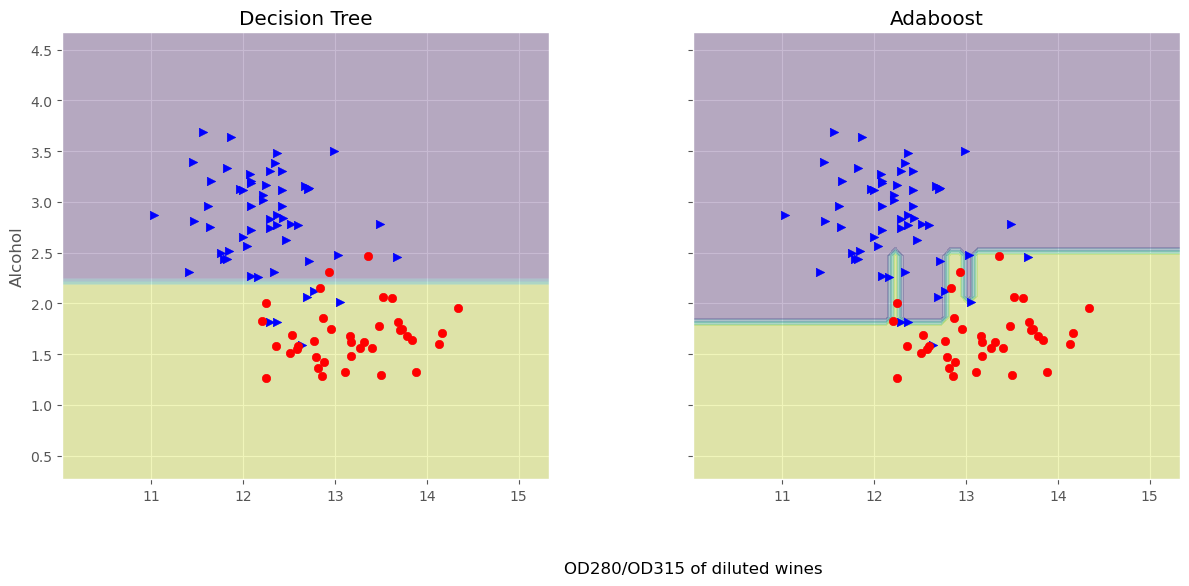

In [72]:
x_min=X_train[:,0].min()-1
x_max=X_train[:,0].max()+1
y_min=X_train[:,1].min()-1
y_max=X_train[:,1].max()+1
xx,yy=np.meshgrid(np.arange(x_min,x_max,0.1), np.arange(y_min,y_max,0.1))
f,axarr=plt.subplots(nrows=1,ncols=2,sharex='col',sharey='row',figsize=(12,6))
for idx,clf,tt in zip([0,1],[tree,ada],['Decision Tree', 'Adaboost']):
    clf.fit(X_train,y_train)
    Z=clf.predict(np.c_[xx.ravel(),yy.ravel()])
    Z=Z.reshape(xx.shape)
    axarr[idx].contourf(xx,yy,Z,alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0][:,0],X_train[y_train==0][:,1],c='blue',marker='>')
    axarr[idx].scatter(X_train[y_train==1][:,0],X_train[y_train==1][:,1],c='red',marker='o')
    axarr[idx].set_title(tt)
    
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(0, -0.2,s='OD280/OD315 of diluted wines',ha='center',va='center',fontsize=12,transform=axarr[1].transAxes)
plt.tight_layout()
plt.show()

Adaboost模型的决策边界比单层决策树的决策边界要复杂的多。也就是说，Adaboost试图用增加模型复杂度而降低偏差的方式去减少总误差，但是过程中引入了方差，可能出现国拟合，因此在训练集和测试集之间的性能存在较大的差距，这就简单地回答的刚刚问题。值的注意的是：与单个分类器相比，Adaboost等Boosting模型增加了计算的复杂度，在实践中需要仔细思考是否愿意为预测性能的相对改善而增加计算成本，而且Boosting方式无法做到现在流行的并行计算的方式进行训练，因为每一步迭代都要基于上一部的基本分类器。